<a href="https://colab.research.google.com/github/cric96/DL-exercise/blob/main/DL_01_traffic_volume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary part

## Important imports

library reference:
- [pandas](https://pandas.pydata.org/docs/)
- [matplotlib](https://matplotlib.org/)
- [numpy](https://numpy.org/doc/stable/)
- [sklearn](https://scikit-learn.org/stable/)
- [tensorflow](https://www.tensorflow.org/api_docs)
- [seabord](https://seaborn.pydata.org/)

In [ ]:
import glob 
from datetime import datetime
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sb
from xgboost import XGBRegressor ##Another reference as regressor

seed = 42

## Dataset gathering

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz

!gzip -d Metro_Interstate_Traffic_Volume.csv.gz

--2021-03-17 09:30:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405373 (396K) [application/x-httpd-php]
Saving to: ‘Metro_Interstate_Traffic_Volume.csv.gz’

Metro_Interstate_Tr 100%[===================>] 395.87K  1.20MB/s    in 0.3s    

2021-03-17 09:30:55 (1.20 MB/s) - ‘Metro_Interstate_Traffic_Volume.csv.gz’ saved [405373/405373]



In [ ]:
def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_xlim([1,epoch_count])
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

def plot_prediction_results(y,y_pred,output_labels,bin_count=50):
  fig, axs = plt.subplots(2,len(output_labels),figsize=(25, 10))
  
  for i in range(len(output_labels)):
    axs[0,i].set_title(output_labels[i])
    axs[0,i].scatter(y[:,i], y_pred[:,i],s=1)
    axs[0,i].set_xlabel('True Values')
    if i==0:
      axs[0,i].set_ylabel('Predictions')
    max_value=max(max(y[:,i]),max(y_pred[:,i]))
    x_lims = [0, max_value]
    y_lims = [min(0,min(y[:,i]),min(y_pred[:,i])), max_value]
    axs[0,i].set_xlim(x_lims)
    axs[0,i].set_ylim(y_lims)
    axs[0,i].plot(y_lims, y_lims, color='k')

    errors = y[:,i]-y_pred[:,i]
    axs[1,i].hist(errors, bins=bin_count)
    axs[1,i].set_xlabel('Prediction Error')
    if i==0:
      axs[1,i].set_ylabel('Count')
    axs[1,i].set_xlim([min(errors),max(errors)])

def plot_prediction_results(y,y_pred,output_labels,bin_count=50):
  fig, axs = plt.subplots(2,len(output_labels),figsize=(25, 10))

  def init_plot(top_plot, bottom_plot):
    top_plot.set_ylabel('Predictions')
    bottom_plot.set_ylabel('Count')
    
  def plot_single(top_plot, bottom_plot, y, y_pred, label):
    top_plot.set_title(label)
    top_plot.scatter(y, y_pred, s = 1)
    top_plot.set_xlabel('True Values')
    
    max_value=max(max(y),max(y_pred))
    x_lims = [0, max_value]
    y_lims = [min(0,min(y),min(y_pred)), max_value]
    top_plot.set_xlim(x_lims)
    top_plot.set_ylim(y_lims)
    top_plot.plot(y_lims, y_lims, color='k')

    errors = y - y_pred
    bottom_plot.hist(errors, bins=bin_count)
    bottom_plot.set_xlabel('Prediction Error')
    bottom_plot.set_xlim([min(errors),max(errors)])

  if len(output_labels) == 1:
    init_plot(axs[0], axs[1])
    plot_single(axs[0], axs[1], y, y_pred, output_labels[0])
  else:
    init_plot(axs[0,0], axs[1,0])
    for i in range(len(output_labels)):
      plot_single(axs[0,i], axs[1, i], y[:,i], y_pred[:,i], output_labels[i])

## Dataset analisys and trasformation
Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

**Attributes**
- holiday Categorical US National holidays plus regional holiday, Minnesota State Fair
- temp Numeric Average temp in kelvin
- rain_1h Numeric Amount in mm of rain that occurred in the hour
- snow_1h Numeric Amount in mm of snow that occurred in the hour
- clouds_all Numeric Percentage of cloud cover
- weather_main Categorical Short textual description of the current weather
- weather_description Categorical Longer textual description of the current weather
- date_time DateTime Hour of the data collected in local CST time
traffic_volume Numeric Hourly I-94 ATR 301 reported westbound traffic volume



### Basic analysis

In [ ]:
data_set = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", header = 0, encoding = "unicode_escape", sep = ",")

In [ ]:
data_set.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [ ]:
data_set.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
9626,None,275.39,0.0,0.0,90,Clouds,overcast clouds,2013-10-23 10:00:00,4665
1599,None,273.09,0.0,0.0,90,Mist,mist,2012-12-01 08:00:00,2953
37900,None,282.08,0.0,0.0,90,Rain,light rain,2017-10-09 18:00:00,4282
20413,None,265.93,0.0,0.0,90,Mist,mist,2016-01-04 21:00:00,1902
2944,None,257.57,0.0,0.0,1,Clear,sky is clear,2013-01-15 04:00:00,731


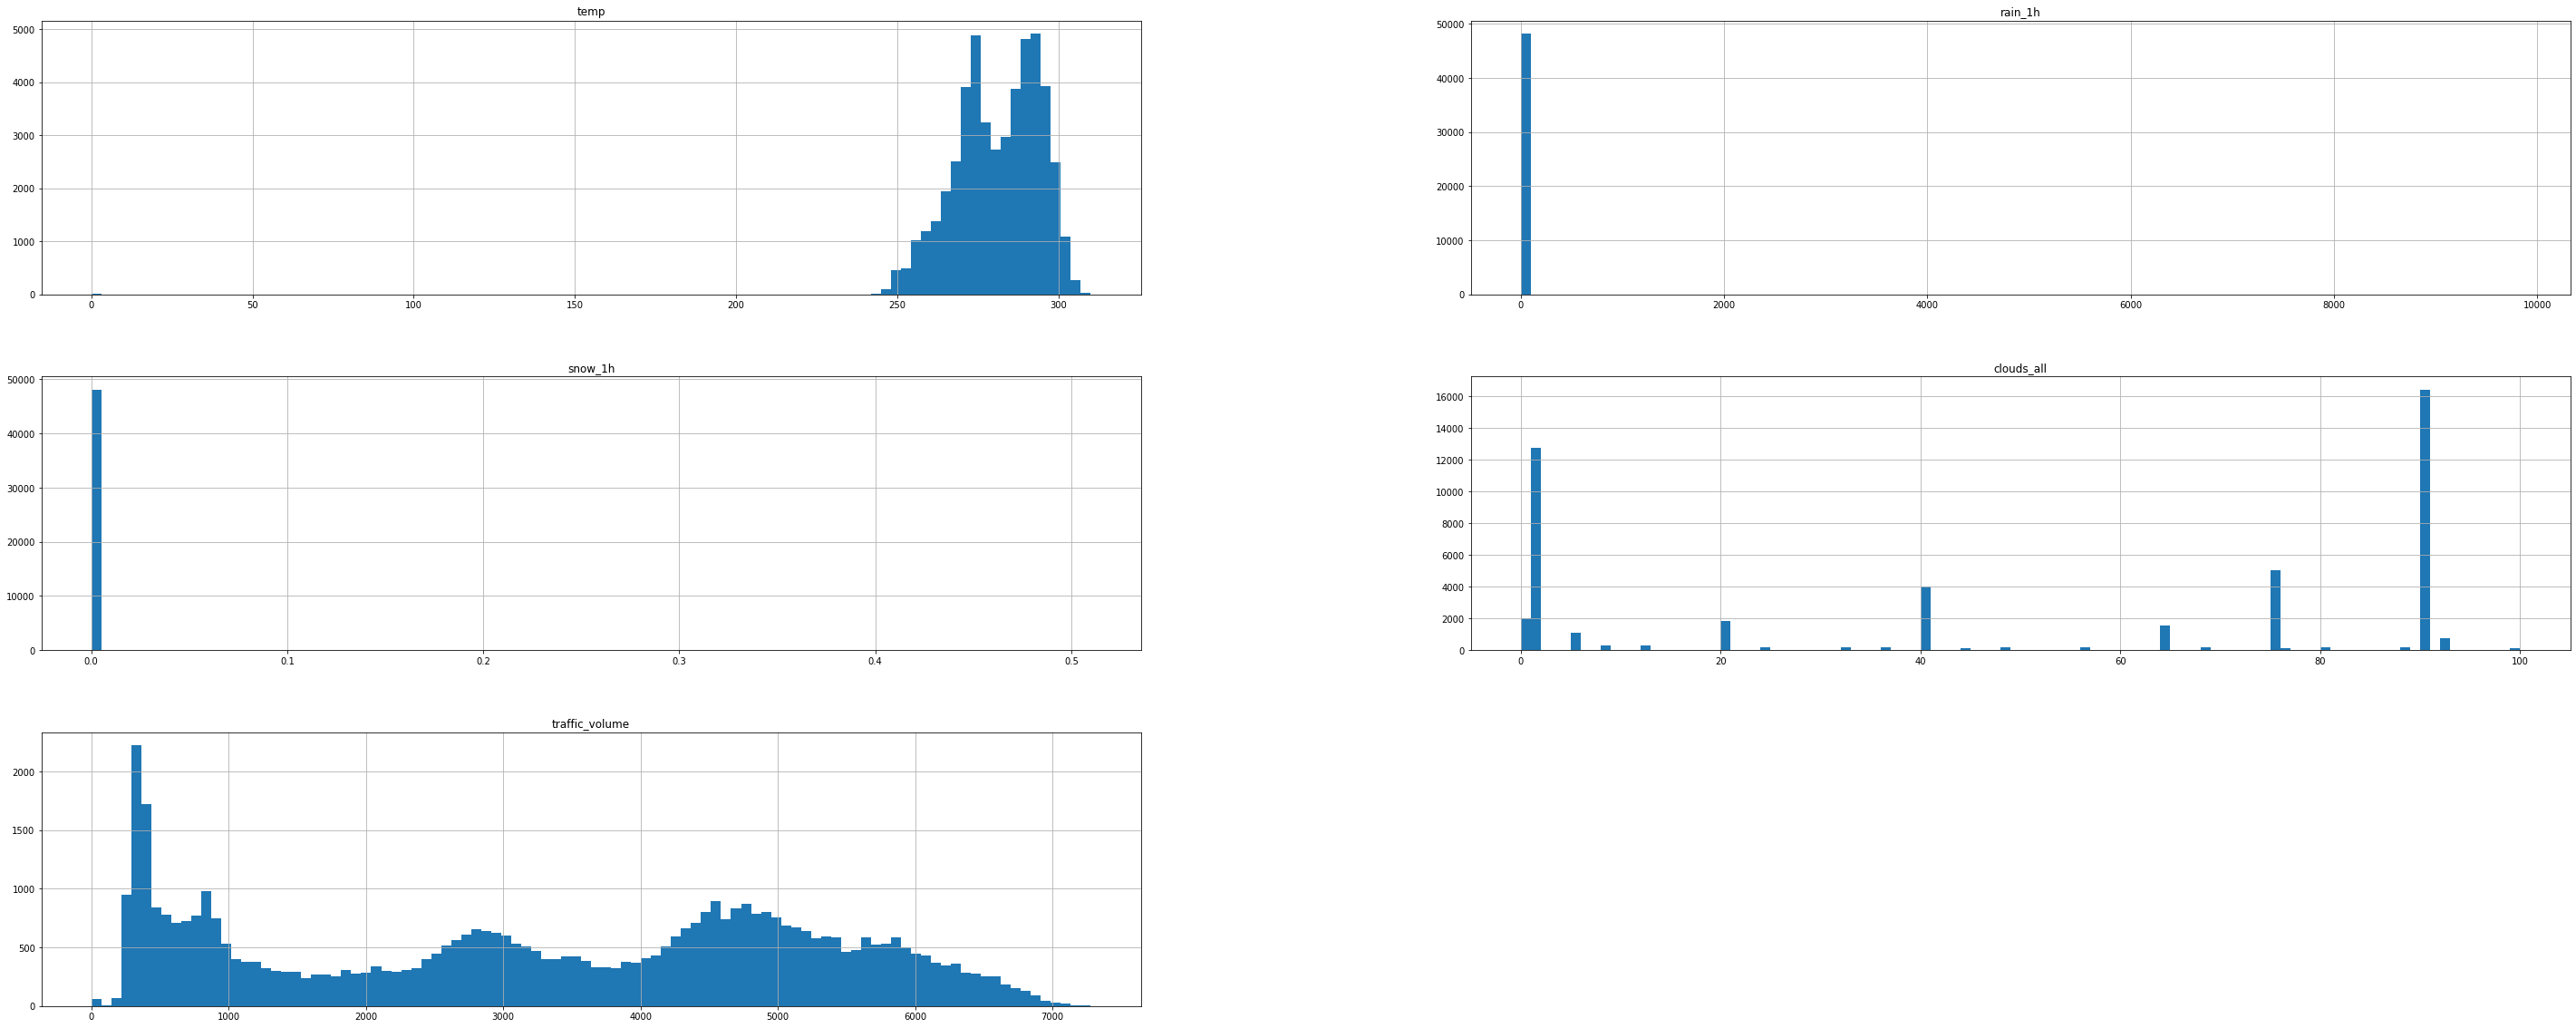

In [ ]:
## Visual information about data
data_set.hist(bins = 100, figsize = (50, 20))
plt.show()

In [ ]:
data_set.columns ## Get all attributes

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff5f156450>,
      dtype=object)

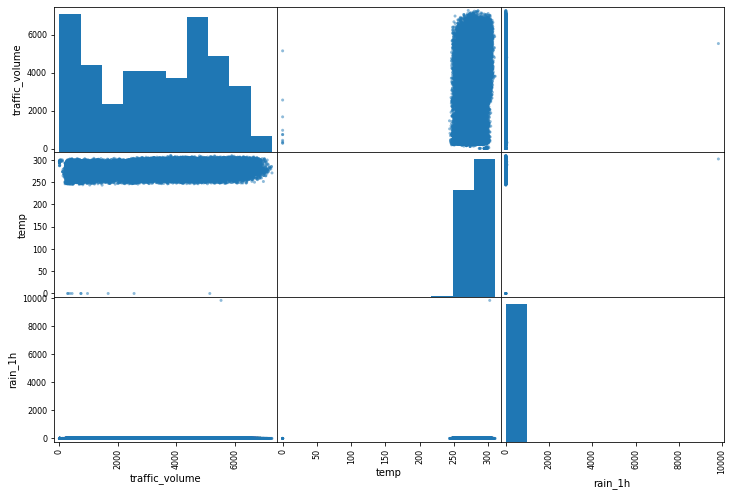

In [ ]:
# Correlation between revelevant data
correlation_with_target = ["traffic_volume", "temp", "rain_1h"]
scatter_matrix(data_set[correlation_with_target], figsize = (12, 8))

In [ ]:
corr_matrix = data_set.corr()
corr_matrix["traffic_volume"].sort_values(ascending = False)

traffic_volume    1.000000
temp              0.130299
clouds_all        0.067054
rain_1h           0.004714
snow_1h           0.000733
Name: traffic_volume, dtype: float64

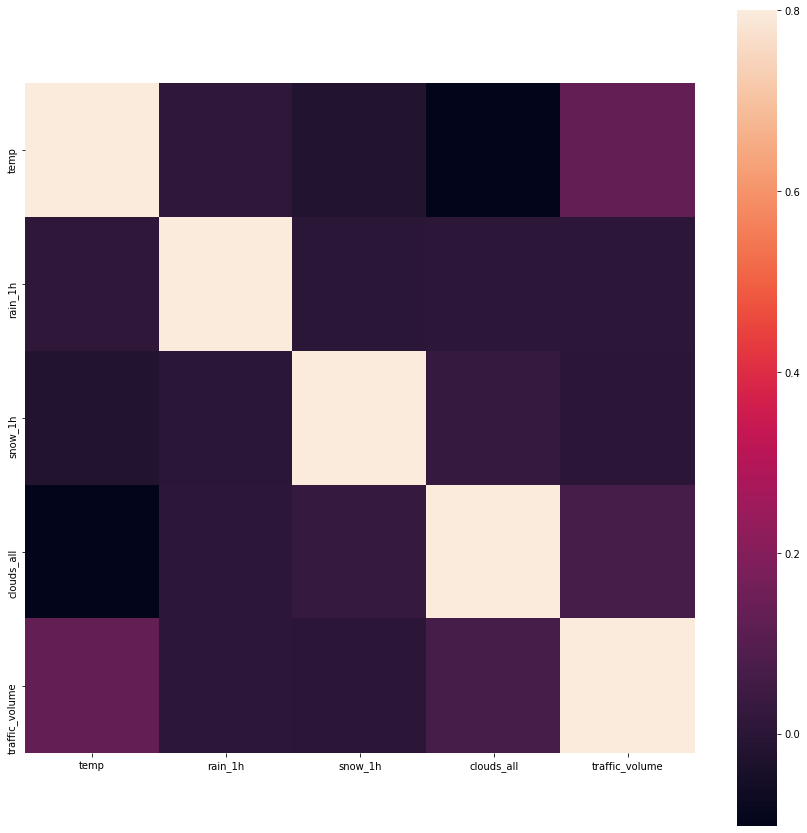

In [ ]:
fig = plt.figure(figsize = (15,15))
sb.heatmap(corr_matrix, vmax = .8, square = True)
plt.show()

## Categorial Encoding


In [ ]:
reference = data_set.copy()
## label encoding 
def label_decoder(attr, df):
  res = df[[attr]]
  encoder = OrdinalEncoder()
  return encoder.fit_transform(res)

## Ad-hoc encoding for holiday
def holiday_decoder(holiday):
  return 0 if str(holiday) == "None" else 1

## Ad-hoc encoding for weekday
def day_encoder(date):
  converted = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
  return converted.weekday()

def month_encoder(date):
  converted = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
  return converted.month

def hour_encoder(date):
  converted = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
  return converted.hour

reference["holiday"] = reference["holiday"].apply(holiday_decoder)
reference["weekday"] = reference["date_time"].apply(day_encoder)
reference["month"] = reference["date_time"].apply(month_encoder)
reference["hour"] = reference["date_time"].apply(hour_encoder)
reference = pd.get_dummies(reference, columns=["weather_main"], prefix=["Weather"])
reference.sample(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_description,date_time,traffic_volume,weekday,month,hour,Weather_Clear,Weather_Clouds,Weather_Drizzle,Weather_Fog,Weather_Haze,Weather_Mist,Weather_Rain,Weather_Smoke,Weather_Snow,Weather_Squall,Weather_Thunderstorm
7768,0,301.370,0.0,0.0,12,moderate rain,2013-07-18 21:00:00,3041,3,7,21,0,0,0,0,0,0,1,0,0,0,0
36749,0,291.720,0.0,0.0,1,mist,2017-08-30 00:00:00,664,2,8,0,0,0,0,0,0,1,0,0,0,0,0
27236,0,293.495,0.0,0.0,0,Sky is Clear,2016-10-10 13:00:00,4426,0,10,13,1,0,0,0,0,0,0,0,0,0,0
42998,0,262.750,0.0,0.0,1,light snow,2018-04-07 01:00:00,657,5,4,1,0,0,0,0,0,0,0,0,1,0,0
32250,0,286.860,0.0,0.0,40,scattered clouds,2017-03-31 19:00:00,4226,4,3,19,0,1,0,0,0,0,0,0,0,0,0
35685,0,295.610,0.0,0.0,90,proximity thunderstorm,2017-07-26 05:00:00,2900,2,7,5,0,0,0,0,0,0,0,0,0,0,1
21690,0,276.940,0.0,0.0,90,light intensity drizzle,2016-03-09 18:00:00,4639,2,3,18,0,0,1,0,0,0,0,0,0,0,0
47558,0,293.530,0.0,0.0,1,sky is clear,2018-09-09 13:00:00,3993,6,9,13,1,0,0,0,0,0,0,0,0,0,0
11103,0,255.370,0.0,0.0,64,broken clouds,2013-12-30 18:00:00,3041,0,12,18,0,1,0,0,0,0,0,0,0,0,0
28454,0,274.030,0.0,0.0,90,mist,2016-11-25 08:00:00,2024,4,11,8,0,0,0,0,0,1,0,0,0,0,0


traffic_volume    1.000000
temp              0.130299
clouds_all        0.067054
rain_1h           0.004714
snow_1h           0.000733
Name: traffic_volume, dtype: float64


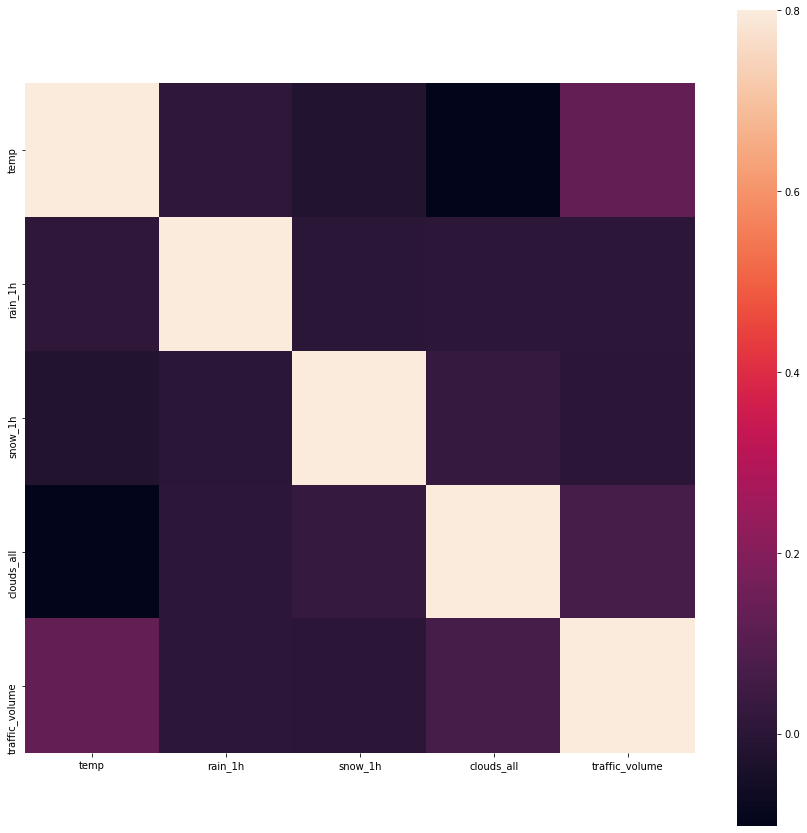

KeyError: ignored

In [ ]:
corr_matrix = reference.corr()
print(corr_matrix["traffic_volume"].sort_values(ascending = False))
fig = plt.figure(figsize = (15,15))
sb.heatmap(corr_matrix, vmax = .8, square = True)
plt.show()

correlation_with_target = ["traffic_volume", "hour", "weekday", "month", "holiday"] ## month seems that don't give any information
scatter_matrix(reference[correlation_with_target], figsize = (12, 8))

## Data cleaning

In [ ]:
reference = reference.copy()
## month don't give any useful information
if "weather_description" in reference.columns:
  reference = reference.drop(["weather_description", "date_time", "month"], axis = 1)
### seems nothing to clean
reference.sample(1)

,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weekday,hour,Weather_Clear,Weather_Clouds,Weather_Drizzle,Weather_Fog,Weather_Haze,Weather_Mist,Weather_Rain,Weather_Smoke,Weather_Snow,Weather_Squall,Weather_Thunderstorm
47503,0,284.13,0.0,0.0,1,5542,4,6,1,0,0,0,0,0,0,0,0,0,0


# Learninig part


## Data set splitting

In [ ]:
target = ["traffic_volume"]
X = reference.drop(target, axis = 1).values
Y = reference[target].values
test_percentage = 0.25
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = seed, test_size = test_percentage, shuffle = True)

### Scaling the feature

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Reference performance, linear regression

RMSE - Train: 1816.146 Test: 1812.414


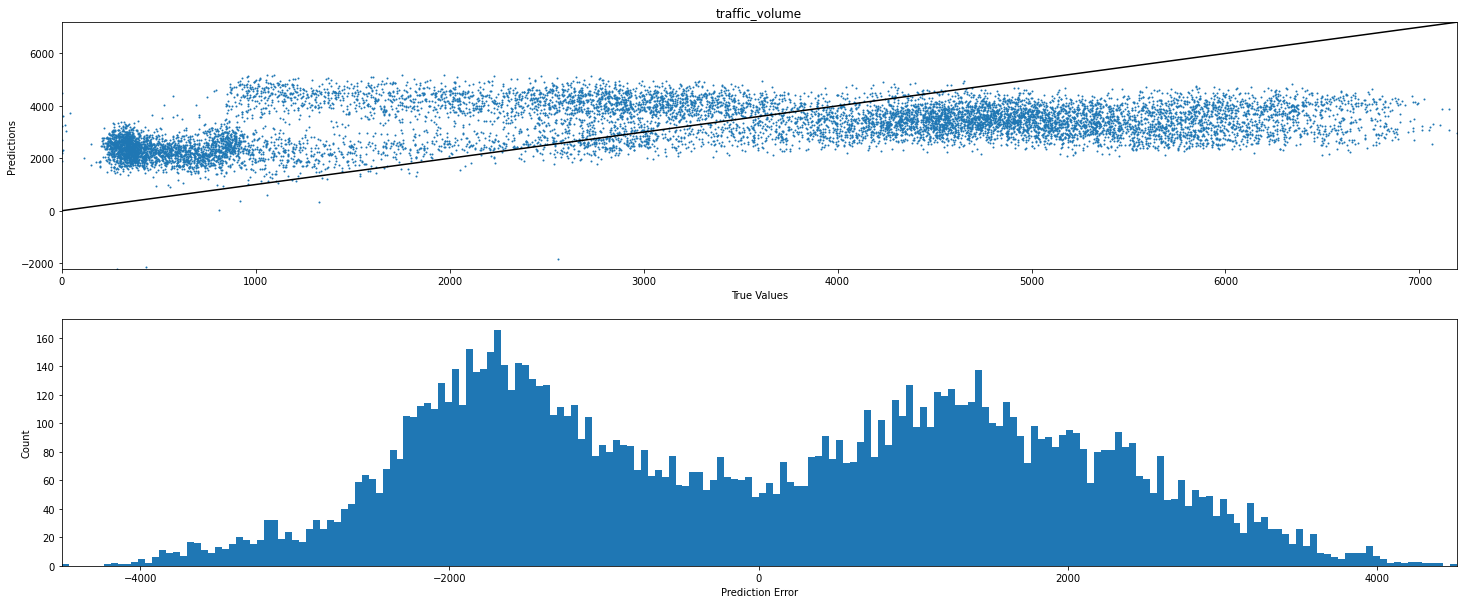

In [ ]:
linear_model = LinearRegression().fit(X_train, Y_train)

rmse_train_error = mean_squared_error(Y_train, linear_model.predict(X_train), squared = False)
rmse_test_error = mean_squared_error(Y_test, linear_model.predict(X_test), squared = False)

print('RMSE - Train: {:.3f} Test: {:.3f}'.format(rmse_train_error, rmse_test_error))
# without additional attributes, 1964
plot_prediction_results(Y_test, linear_model.predict(X_test), target, 200)

## Reference performance, XGB regressor

[10:57:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE - Train: 556.573 Test: 545.774


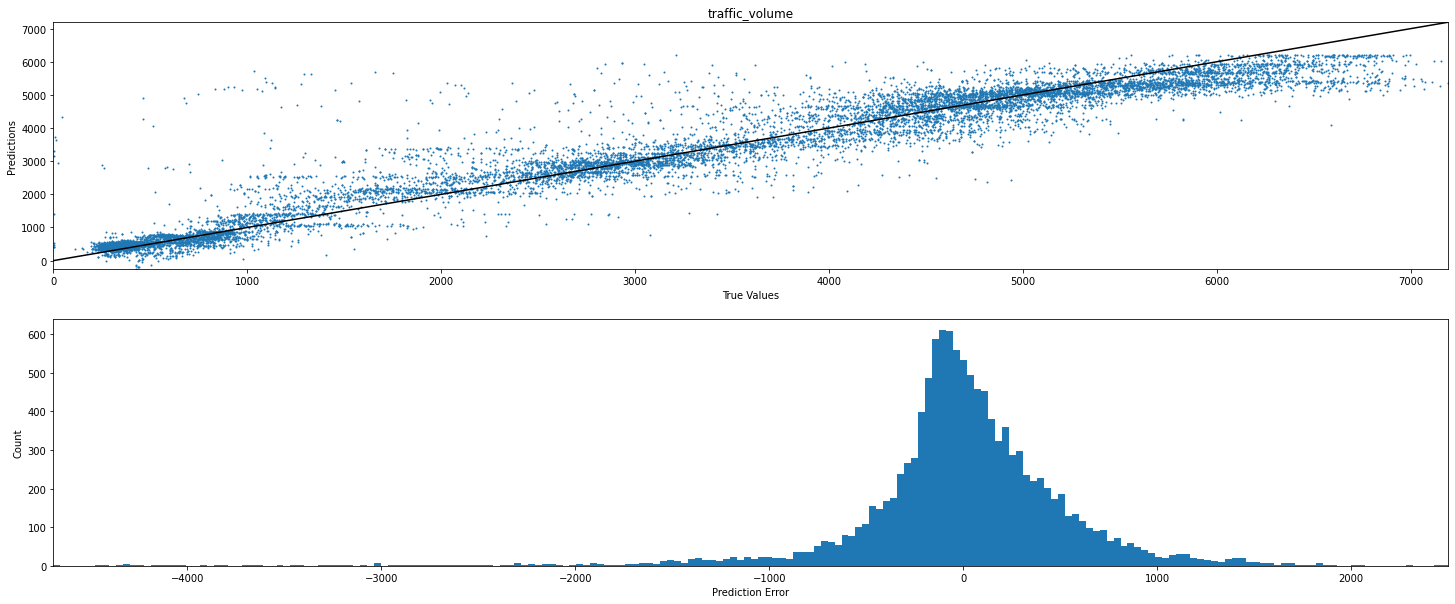

In [ ]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, Y_train)
predition = xgb_regressor.predict(X_test)
to_plot = predition.reshape(predition.shape[0], 1)
rmse_train_error = mean_squared_error(Y_train, xgb_regressor.predict(X_train), squared = False)
rmse_test_error = mean_squared_error(Y_test, predition, squared = False)

print('RMSE - Train: {:.3f} Test: {:.3f}'.format(rmse_train_error, rmse_test_error))
## without additional data : 1903 mse error
plot_prediction_results(Y_test, to_plot, target, 200)

## Deep learning part

### Validation set creation

In [ ]:
val_size = 0.25

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = val_size, random_state = seed,shuffle = True)


In [ ]:
def build_dnn(input_count, output_count, neuron_count_per_hidden_layer = [128, 128], activation='relu'):
  model = keras.Sequential()
  model.add(layers.Input(shape=(input_count)))

  for n in neuron_count_per_hidden_layer:
    
    model.add(layers.Dense(n, activation = activation))

  model.add(layers.Dense(output_count))

  return model

Traning

In [ ]:
epoch_count = 10000
batch_size = 256
sgd_learning_rate = 0.00001
adam_learning_rate = 0.0001
patience = 50
dnn = build_dnn(X_train.shape[1], Y_train.shape[1], [64, 64, 64, 32], activation = 'relu') 
#optimizer = keras.optimizers.SGD(learning_rate = sgd_learning_rate)
#optimizer=keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-07, name="Adadelta")
#optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate)
optimizer = keras.optimizers.Adam(learning_rate = adam_learning_rate)
dnn.compile(loss = 'mse', optimizer = optimizer, metrics = [keras.metrics.RootMeanSquaredError(name = 'rmse')])
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True)

history = dnn.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = epoch_count, batch_size = batch_size, shuffle = True, callbacks= [early_stop])

Streaming output truncated to the last 5000 lines.
Epoch 240/10000
80/80 [==============================] - 0s 3ms/step - loss: 686297.0401 - rmse: 828.4006 - val_loss: 695378.5625 - val_rmse: 833.8936
Epoch 241/10000
80/80 [==============================] - 0s 3ms/step - loss: 678702.6628 - rmse: 823.7126 - val_loss: 694968.3125 - val_rmse: 833.6476
Epoch 242/10000
80/80 [==============================] - 0s 3ms/step - loss: 667658.4498 - rmse: 817.0376 - val_loss: 692805.6875 - val_rmse: 832.3495
Epoch 243/10000
80/80 [==============================] - 0s 3ms/step - loss: 672542.8935 - rmse: 820.0468 - val_loss: 690370.6875 - val_rmse: 830.8855
Epoch 244/10000
80/80 [==============================] - 0s 3ms/step - loss: 661756.4452 - rmse: 813.4464 - val_loss: 688304.0000 - val_rmse: 829.6409
Epoch 245/10000
80/80 [==============================] - 0s 3ms/step - loss: 662521.3418 - rmse: 813.9353 - val_loss: 687505.9375 - val_rmse: 829.1598
Epoch 246/10000
80/80 [====================

### Evaluation

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


RMSE - Train: 482.951 Val: 517.343 Test: 495.055


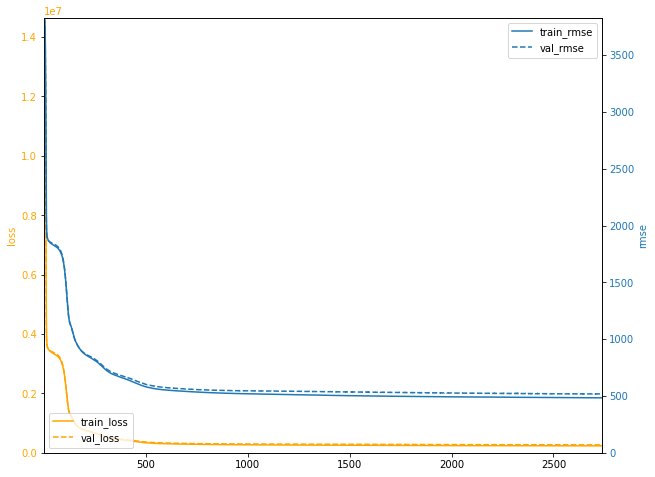

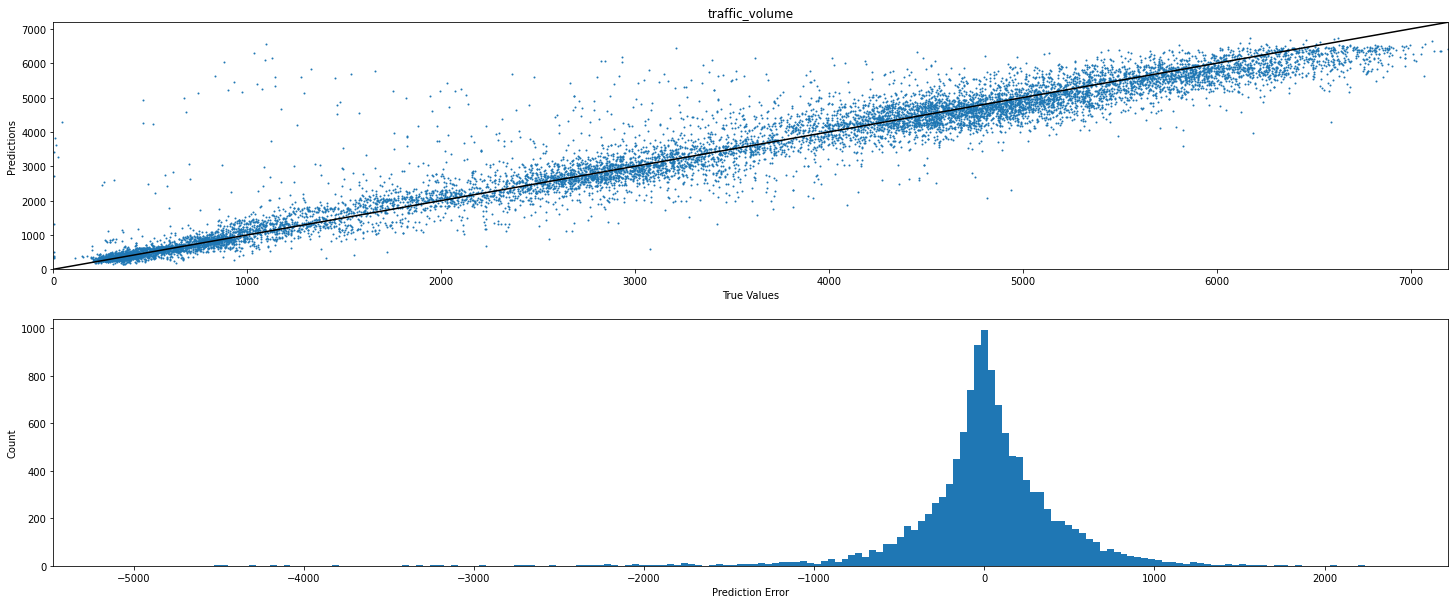

In [ ]:
Y_train_pred = dnn.predict(X_train)
Y_val_pred = dnn.predict(X_val)
Y_test_pred = dnn.predict(X_test)

plot_history(history, 'rmse')
plot_prediction_results(Y_test, Y_test_pred, target, 200)

rmse_train = mean_squared_error(Y_train ,Y_train_pred, squared = False)
rmse_val = mean_squared_error(Y_val, Y_val_pred, squared = False)
rmse_test = mean_squared_error(Y_test, Y_test_pred, squared = False)
# without additional attributes, 1926.419
print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train,rmse_val,rmse_test))

In [ ]:
rmse_test_instances = np.sqrt(mean_squared_error(Y_test.transpose(),Y_test_pred.transpose(),multioutput='raw_values'))

rmse_test_instances_sorted_indices = np.argsort(rmse_test_instances)

row_count = 5

print("Best..")
with np.printoptions(precision = 1, suppress = True):
  print('RMSE:')
  print(rmse_test_instances[rmse_test_instances_sorted_indices[:row_count]])

  print('True values:')
  print(Y_test[rmse_test_instances_sorted_indices[:row_count]])

  print('Predicted values:')
  print(Y_test_pred[rmse_test_instances_sorted_indices[:row_count]])


print("Worst...")

with np.printoptions(precision = 1, suppress = True):
  print('RMSE:')
  print(rmse_test_instances[rmse_test_instances_sorted_indices[-row_count:]])

  print('True values:')
  print(Y_test[rmse_test_instances_sorted_indices[-row_count:]])

  print('Predicted values:')
  print(Y_test_pred[rmse_test_instances_sorted_indices[-row_count:]])

Best..
RMSE:
[0.  0.  0.1 0.1 0.1]
True values:
[[ 362]
 [ 362]
 [ 504]
 [ 656]
 [3974]]
Predicted values:
[[ 362. ]
 [ 362. ]
 [ 504.1]
 [ 655.9]
 [3973.9]]
Worst...
RMSE:
[4988.4 5033.2 5148.2 5267.6 5471.6]
True values:
[[1091]
 [1128]
 [ 882]
 [1036]
 [1094]]
Predicted values:
[[6079.4]
 [6161.2]
 [6030.2]
 [6303.6]
 [6565.6]]
